In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import beta, binom, betabinom, chi2
import arviz as az

In [13]:
n = 9
x = 6
a = 1
b = 1

a_posterior = a+x
b_posterior = b+n-x

In [14]:
theta_grid = np.linspace(0, 1, num=200)
x_grid     = np.arange(0, 10)
likelihood = beta.pdf(theta_grid, x+1, n-x+1)
prior      = beta.pdf(theta_grid, a, b)
posterior  = beta.pdf(theta_grid, a_posterior, b_posterior)

posterior_approx = prior * likelihood

### Plot the (exact) prior, likelihood and posterior

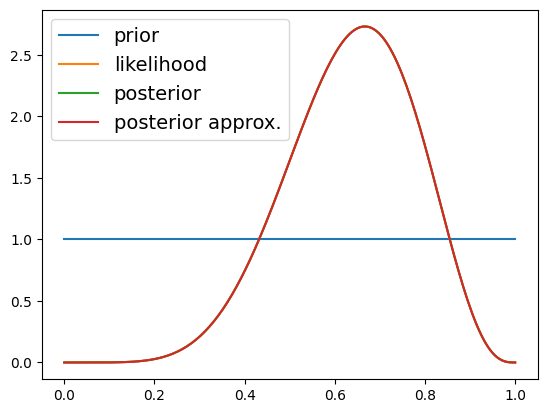

In [25]:
#plt.figure(figsize=(12,10))
plt.plot(theta_grid, prior, label='prior')
plt.plot(theta_grid, likelihood, label='likelihood')
plt.plot(theta_grid, posterior, label='posterior')
plt.plot(theta_grid, posterior_approx, label='posterior approx.')
plt.legend(fontsize=14)

### Plot the previous and posterior predictives

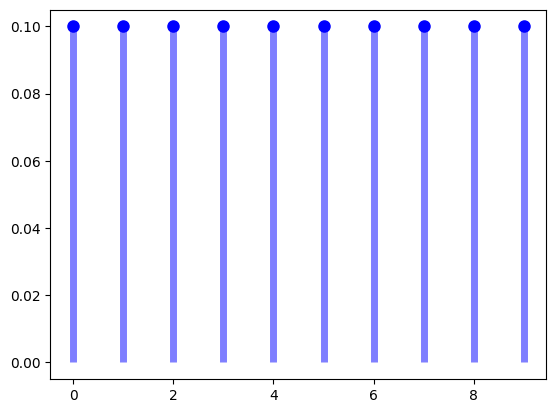

In [16]:
fig, ax = plt.subplots(1, 1) #figsize=(12,10)
ax.plot(x_grid, betabinom.pmf(x_grid, n, a, b), 'bo', ms=8)
ax.vlines(x_grid, 0, betabinom.pmf(x_grid, n, a, b), colors='b', lw=5, alpha=0.5)

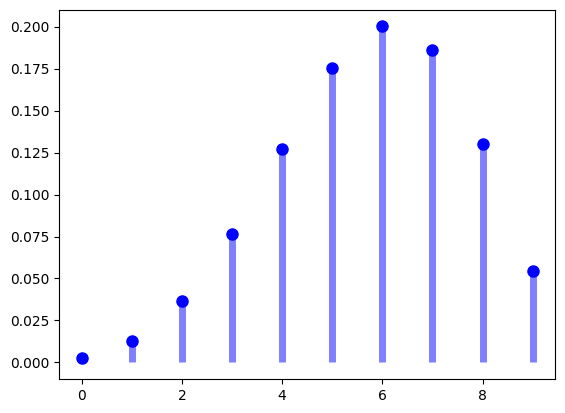

In [17]:
fig, ax = plt.subplots(1, 1) #figsize=(12,10)
ax.plot(x_grid, betabinom.pmf(x_grid, n, a_posterior, b_posterior), 'bo', ms=8)
ax.vlines(x_grid, 0, betabinom.pmf(x_grid, n, a_posterior, b_posterior), colors='b', lw=5, alpha=0.5)

### Simulate from the posterior and from the posterior predictive

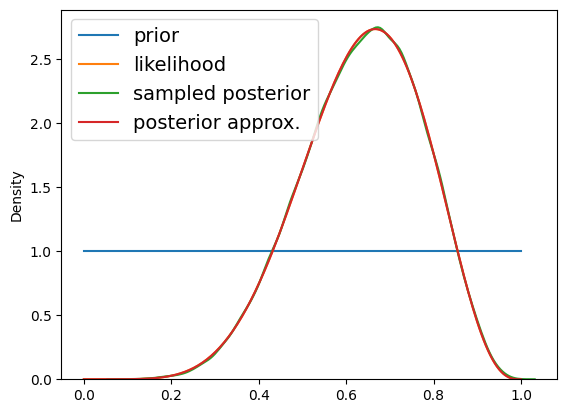

In [27]:
n_sample = 10**5
posterior_sample = random.choices(theta_grid, weights=posterior_approx, k=n_sample)

plt.plot(theta_grid, prior, label='prior')
plt.plot(theta_grid, likelihood, label='likelihood')
sns.kdeplot(posterior_sample, label='sampled posterior')
plt.plot(theta_grid, posterior_approx, label='posterior approx.')
plt.legend(fontsize=14)

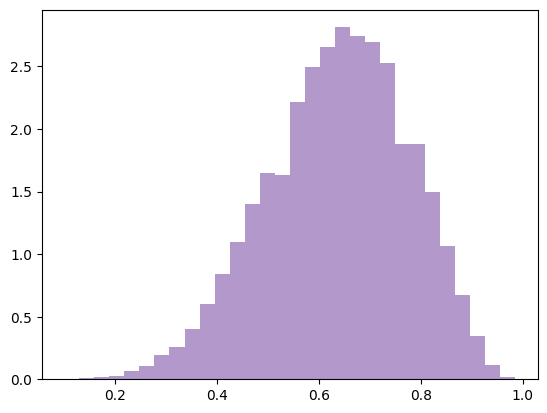

In [23]:
hist = plt.hist(posterior_sample, bins=30, density=True, color='RebeccaPurple', alpha=0.5)

<BarContainer object of 30 artists>

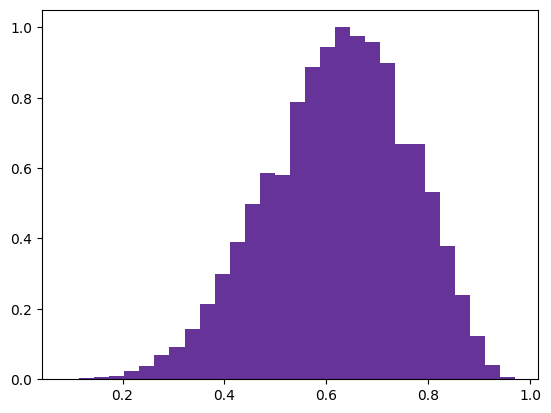

In [24]:
width = (np.diff(hist[1]))[0]
middle_points = hist[1][:-1]
normalized_heights = hist[0] / hist[0].max()
plt.bar(middle_points, normalized_heights, width, color='RebeccaPurple')

Using the normal apporximation to get a credible interval of 0.5 probability

In [10]:
alpha = 0.23
point_cut = np.exp(-0.5 * chi2.ppf(1-alpha, 1))
extreme_points = middle_points[normalized_heights >= point_cut][[0,-1]]

extreme_points

array([0.47102178, 0.81005025])

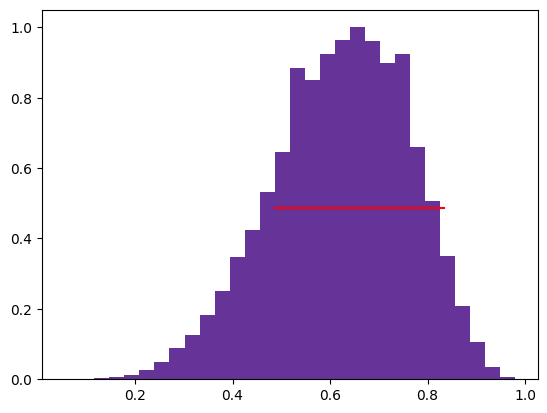

In [11]:
plt.bar(middle_points, normalized_heights, width, color='RebeccaPurple')
plt.axhline(point_cut, extreme_points[0], extreme_points[1], color='r')

<AxesSubplot:ylabel='Probability'>

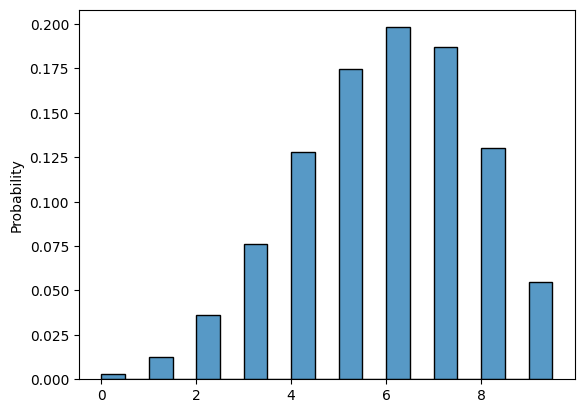

In [12]:
posterior_predictive = binom.rvs(size=n_sample, n=9, p=posterior_sample)
sns.histplot(posterior_predictive, stat='probability', bins=np.arange(0,10,0.5))

### Punctual estimation

In [13]:
posterior_sample = pd.Series(posterior_sample)

### MAP (Maximum a posteriori) $\frac{\alpha-1}{\alpha+\beta-2}$

In [14]:
print('Theoretical MAP: ', (a_posterior-1) / (a_posterior+b_posterior-2))
print('Mode from posteior sample: ', posterior_sample.mode().values[0])

Theoretical MAP:  0.6666666666666666
Mode from posteior sample:  0.6582914572864321


### Posterior mean $\frac{\alpha}{\alpha+\beta}$

In [15]:
print('Theoretical mean a posteriori: ', (a_posterior) / (a_posterior+b_posterior))
print('Mean from posteior sample: ', posterior_sample.mean())

Theoretical mean a posteriori:  0.6363636363636364
Mean from posteior sample:  0.6364018592964825


### Posterior median $\approx \frac{\alpha-1/3}{\alpha+\beta-2/3}$

In [16]:
print('Approx. median a posteriori: ', (a_posterior-1/3) / (a_posterior+b_posterior-2/3))
print('Mode from posteior sample: ', posterior_sample.median())

Approx. median a posteriori:  0.6451612903225806
Mode from posteior sample:  0.6432160804020101


### Using loss functions

In [17]:
def quadratic_loss(p):
    return(sum(posterior_approx*1/2*(p-theta_grid)**2))

In [18]:
approx_quad_loss = np.array([quadratic_loss(p) for p in theta_grid])
theta_grid[approx_quad_loss.argmin()]

0.6381909547738693

In [19]:
def absolute_loss(p):
    return(sum(posterior_approx*abs(p-theta_grid)))

In [20]:
approx_abs_loss = np.array([absolute_loss(p) for p in theta_grid])
theta_grid[approx_abs_loss.argmin()]

0.6432160804020101

In [21]:
def huber_loss(p, delta=1):
    aux = np.where(np.abs(p-theta_grid) < delta, 1/2*(p-theta_grid)**2 , delta*(np.abs(p-theta_grid)-1/2*delta))
    return(sum(aux))

In [22]:
approx_huber_loss = np.array([huber_loss(p) for p in theta_grid])
theta_grid[approx_huber_loss.argmin()]

0.49748743718592964

### Interval estimation

### Credible interval

In [23]:
# Usiing normal approximation

alpha = 0.23
point_cut = np.exp(-0.5 * chi2.ppf(1-alpha, 1))
extreme_points = middle_points[normalized_heights >= point_cut][[0,-1]]

extreme_points

array([0.47102178, 0.81005025])

In [24]:
print(beta.ppf(alpha/2, a_posterior, b_posterior), beta.ppf(1-alpha/2, a_posterior, b_posterior))
print(posterior_sample.quantile(alpha/2), posterior_sample.quantile(1-alpha/2))

0.46074703703217906 0.8033773374353778
0.4623115577889447 0.8040201005025126


### Highest posterior density interval (HPDI)

In [25]:
az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)

array([0.55276382, 0.74371859])

### Hypothesis test

$\theta \geq 0.5$

In [26]:
sum(posterior_sample >= 0.5) / n_sample

0.82855

$\theta \geq 0.9$

In [27]:
sum(posterior_sample >= 0.9) / n_sample

0.01214